In [93]:
#PLEASE RUN THIS CELL 
import requests
import os
import glob, cv2
import tarfile
import requests
import getpass
import sys
import logging
import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from skimage.io import imread
import skimage.transform
from scipy.misc import imresize
from scipy.stats import norm
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC

from keras import backend as K
from keras_preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.callbacks import EarlyStopping
from keras.models import Sequential, Model, load_model
from keras.layers import Dropout, Flatten, Dense, Conv2D, MaxPooling2D, Input, Reshape, UpSampling2D, InputLayer, Lambda, ZeroPadding2D, Cropping2D, Conv2DTranspose, BatchNormalization
from keras.utils import np_utils, to_categorical
from keras.losses import binary_crossentropy
from keras import backend as K,objectives
from keras.losses import mse, binary_crossentropy
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam, RMSprop
from keras.initializers import RandomNormal
from keras.layers import *
import random
from IPython.display import clear_output

from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

#os.getcwd()

In [94]:
# Read in the UTKFace landmarks and labels
os.chdir('/jupyteruser/41400447/Project')
# Extract meta data and/or read it into data frames
utkLandmarks1 = pd.read_csv('landmark_list_part1.txt',quotechar='"',skipinitialspace=True, delimiter=' ',header=None, usecols=[0])

display(utkLandmarks1.shape)
display(utkLandmarks1.head())

(9780, 1)

,0
0,1_0_2_20161219140530307.jpg
1,1_0_2_20161219140525218.jpg
2,1_0_2_20161219140540938.jpg
3,6_1_2_20161219140554092.jpg
4,1_1_2_20161219140604000.jpg


In [95]:
utkLandmarks11 = pd.DataFrame(utkLandmarks1[0].str.split('_').tolist(),
                                   columns = ['age','gender','race','img_id'])

In [177]:
utkLandmarks11['img_file']=utkLandmarks11.age+'_'+utkLandmarks11.gender+"_"+utkLandmarks11.race+'_'+utkLandmarks11.img_id
utkLandmarks11=utkLandmarks11.loc[utkLandmarks11['img_file'].str.contains('nan')==False]

In [178]:
utkLandmarks11.head()

,age,gender,race,img_id,img_file
0,1,0,2,20161219140530307.jpg,1_0_2_20161219140530307.jpg
1,1,0,2,20161219140525218.jpg,1_0_2_20161219140525218.jpg
2,1,0,2,20161219140540938.jpg,1_0_2_20161219140540938.jpg
3,6,1,2,20161219140554092.jpg,6_1_2_20161219140554092.jpg
4,1,1,2,20161219140604000.jpg,1_1_2_20161219140604000.jpg


In [179]:
utkLandmarks11.img_file.isnull().sum()

0

In [184]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, labels, batch_size=32, dim=(32,32,32), n_channels=1,
                 n_classes=10, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            #X[i,] = np.load('data/' + ID + '.npy')   
            print('samata',ID)
            X[i,] =imread('crop_part1/'+str(ID)+'.chip.jpg')
            # Store class
            
            y[i] = pd.to_numeric(self.labels[i])
            #print('samata',y[i])
        #return X, keras.utils.to_categorical(y, num_classes=self.n_classes)
        return X, y

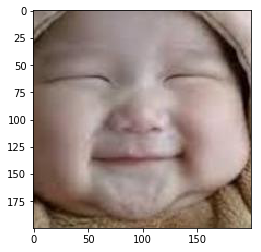

In [185]:
img = imread('/jupyteruser/41400447/Project/crop_part1/1_0_2_20161219140530307.jpg.chip.jpg')
plt.imshow(img)

In [186]:
list_IDs=utkLandmarks11['img_file'].tolist()
labels=utkLandmarks11['gender'].tolist()

In [187]:
utk_datagen=DataGenerator(list_IDs, labels, batch_size=32, dim=(200,200), n_channels=3, n_classes=2)

In [188]:
gw_cnn = Sequential() # Create sequential model

# Add convolution layers
gw_cnn.add(Conv2D(10, (5, 5), padding='same', activation='relu', input_shape=(200, 200,3)))
gw_cnn.add(Dropout(0.01))
gw_cnn.add(Conv2D(10, (3, 3), padding='same', activation='relu', name = 'hlayer1'))
# gw_cnn.add(Conv2D(32, (3, 3), padding='same', activation='relu', name = 'hlayer2'))
# gw_cnn.add(Conv2D(32, (3, 3), padding='same', activation='relu', name = 'hlayer3'))
gw_cnn.add(MaxPooling2D((2, 2), name = 'hlayer4'))
gw_cnn.add(Conv2D(5, (3, 3), padding='same', activation='relu'))
gw_cnn.add(Conv2D(5, (3, 3), padding='same', activation='relu'))
gw_cnn.add(MaxPooling2D((2, 2)))
# flatten and add output layer
gw_cnn.add(Flatten())
gw_cnn.add(Dropout(0.01))
gw_cnn.add(Dense(10, activation='relu', name = 'hlayer5'))
gw_cnn.add(Dense(1, activation='sigmoid', name = 'olayer'))
#summary
gw_cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_58 (Conv2D)           (None, 200, 200, 10)      760       
_________________________________________________________________
dropout_42 (Dropout)         (None, 200, 200, 10)      0         
_________________________________________________________________
hlayer1 (Conv2D)             (None, 200, 200, 10)      910       
_________________________________________________________________
hlayer4 (MaxPooling2D)       (None, 100, 100, 10)      0         
_________________________________________________________________
conv2d_59 (Conv2D)           (None, 100, 100, 5)       455       
_________________________________________________________________
conv2d_60 (Conv2D)           (None, 100, 100, 5)       230       
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 50, 50, 5)         0         
__________

In [189]:
gw_cnn.compile(optimizer="RMSprop",loss='binary_crossentropy')

In [190]:
gw_cnn.fit_generator(generator=utk_datagen )

Epoch 1/1
samata 46_0_0_20170104205340845.jpg
samata 46_1_0_20170104170621792.jpg
samata 28_1_4_20170103225940625.jpg
samata 19_1_0_20170105183441000.jpg
samata 60_0_0_20170111203914420.jpg
samata 100_1_2_20170105174847679.jpg
samata 4_1_1_20170109194523891.jpg
samata 38_1_0_20170103183214380.jpg
samata 4_1_0_20170109194222722.jpg
samata 24_1_4_20170103223710519.jpg
samata 29_1_0_20170103182700482.jpg
samata 49_1_0_20170103181519681.jpg
samata 6_1_0_20170109202302115.jpg
samata 31_0_0_20170105173759693.jpg
samata 69_1_0_20170110140940217.jpg
samata 46_1_0_20170109220530862.jpg
samata 33_0_0_20170104192751495.jpg
samata 30_1_4_20170105165132148.jpg
samata 13_0_0_20170110225428740.jpg
samata 50_0_0_20170111171747301.jpg
samata 14_0_0_20170110225725643.jpg
samata 8_0_0_20170110220159954.jpg
samata 80_1_0_20170110122217473.jpg
samata 4_1_2_20161219160314709.jpg
samata 26_1_0_20170109132910372.jpg
samata 1_0_0_20170110213012671.jpg
samata 20_1_2_20170108224234471.jpg
samata 50_0_0_201701111

samata 9_0_1_20170110225103801.jpg
samata 49_1_0_20170109142131660.jpg
samata 10_0_1_20170104010841239.jpg
samata 11_1_0_20170109205211093.jpg
samata 43_1_0_20170103183515393.jpg
samata 72_1_0_20170110182012800.jpg
samata 44_0_0_20170104210247572.jpg
samata 65_1_0_20170110131349129.jpg
samata 86_1_2_20170110132518353.jpg
samata 27_1_4_20170103210539730.jpg
samata 8_1_0_20170109203450522.jpg
samata 1_1_4_20170109193938953.jpg
samata 59_0_0_20170104212234005.jpg
samata 54_0_2_20170109012851763.jpg
samata 25_0_0_20170104214616710.jpg
samata 10_0_0_20170110220654150.jpg
samata 2_0_2_20161219141643337.jpg
samata 38_0_2_20170109013216517.jpg
samata 18_1_4_20170103223037503.jpg
samata 16_0_0_20170104012330536.jpg
samata 56_0_4_20170105173517933.jpg
samata 67_0_0_20170111193821219.jpg
samata 21_0_4_20161223214836609.jpg
samata 66_1_0_20170110140711170.jpg
samata 1_1_4_20161221201836401.jpg
samata 26_0_4_20170103235429853.jpg
samata 5_1_0_20170109192114580.jpg
samata 25_1_4_20170103180849713.jp

samata 5_0_4_20170103210509634.jpg
samata 60_1_0_20170110125212119.jpg
samata 54_0_0_20170111195744986.jpg
samata 25_1_0_20170103175619551.jpg
samata 65_1_0_20170110133937781.jpg
samata 66_1_0_20170110141754767.jpg
samata 7_1_2_20161219160329535.jpg
samata 4_1_0_20170109192825550.jpg
samata 30_0_0_20170104201611041.jpg
samata 56_1_0_20170109220552870.jpg
samata 23_1_0_20170105002627948.jpg
samata 6_1_0_20170109201859697.jpg
samata 86_1_0_20170110183800477.jpg
samata 23_1_2_20170104015902116.jpg
samata 53_0_0_20170111201804638.jpg
samata 26_0_2_20170104023216134.jpg
samata 18_1_0_20170105002457379.jpg
samata 80_0_0_20170111211335909.jpg
samata 10_0_1_20170110223455893.jpg
samata 39_1_0_20170105164247586.jpg
  7/260 [..............................] - ETA: 1:20 - loss: 8.3043samata 33_1_0_20170103181937009.jpg
samata 50_0_1_20170111203545405.jpg
samata 15_1_4_20170103234910356.jpg
samata 10_0_0_20170110224524253.jpg
samata 8_1_0_20170104005606487.jpg
samata 62_1_0_20170110160643829.jpg
sa

samata 55_0_2_20170104023159589.jpg
samata 32_1_4_20170105164252747.jpg
samata 59_0_0_20170109012750162.jpg
samata 25_1_2_20170104022753590.jpg
samata 80_0_0_20170110183557670.jpg
samata 2_1_1_20170109194159738.jpg
samata 16_1_4_20170104005411807.jpg
samata 8_1_0_20170109203303253.jpg
samata 65_0_0_20170111205215087.jpg
samata 66_1_0_20170110143321085.jpg
samata 1_1_0_20170103213335661.jpg
 14/260 [>.............................] - ETA: 48s - loss: 8.6360samata 45_1_0_20170103181133961.jpg
samata 35_1_2_20170109010122762.jpg
samata 29_0_1_20170104202114602.jpg
samata 25_1_2_20170104200556817.jpg
samata 11_0_0_20170110232511893.jpg
samata 20_0_0_20170104020603909.jpg
samata 4_1_0_20161220220732418.jpg
samata 2_1_4_20170103210839634.jpg
samata 69_1_0_20170109150615726.jpg
samata 14_0_0_20170103200600206.jpg
samata 49_1_1_20170104005312671.jpg
samata 54_1_0_20170105173508749.jpg
samata 1_1_2_20161219210327381.jpg
samata 69_1_0_20170110141304032.jpg
samata 38_1_4_20170105173608614.jpg
sama

samata 55_0_0_20170111202253255.jpg
samata 12_1_2_20170103201240488.jpg
samata 3_1_4_20161221202539569.jpg
samata 60_1_0_20170110143505801.jpg
samata 61_1_0_20170109150858084.jpg
samata 18_0_4_20170103201305015.jpg
samata 15_0_0_20170110225705232.jpg
samata 60_1_0_20170110123158902.jpg
samata 1_0_0_20170103210032258.jpg
samata 3_0_0_20170109191400809.jpg
samata 40_0_4_20170104192730423.jpg
 21/260 [=>............................] - ETA: 38s - loss: 8.7465samata 7_1_0_20170109200828410.jpg
samata 11_1_0_20170109203400684.jpg
samata 42_0_0_20170103181301064.jpg
samata 4_1_0_20170109192357612.jpg
samata 46_1_0_20170104171626722.jpg
samata 9_0_0_20170110220130810.jpg
samata 1_0_2_20161219204858548.jpg
samata 28_0_0_20170104022908893.jpg
samata 65_1_0_20170110131531222.jpg
samata 2_1_2_20161219211744478.jpg
samata 26_0_2_20170104015801932.jpg
samata 17_0_0_20170110232022621.jpg
samata 8_1_0_20170109202901798.jpg
samata 1_1_0_20161219204717605.jpg
samata 15_1_4_20170103201445071.jpg
samata 9

samata 53_0_0_20170104212407239.jpg
samata 14_1_0_20170109203638205.jpg
samata 1_1_0_20170109190844250.jpg
samata 56_0_0_20170104210115763.jpg
samata 29_0_0_20170104192430041.jpg
samata 36_1_0_20170103182343482.jpg
samata 1_0_4_20170103205838610.jpg
samata 20_1_0_20170105183449767.jpg
samata 16_0_0_20170104230001113.jpg
 28/260 [==>...........................] - ETA: 32s - loss: 8.8018samata 93_1_0_20170110182437844.jpg
samata 12_1_0_20170102234723371.jpg
samata 82_0_0_20170111222354407.jpg
samata 10_1_4_20161223225900460.jpg
samata 12_1_0_20170109204750280.jpg
samata 29_0_0_20170104170512993.jpg
samata 53_0_0_20170104184207950.jpg
samata 51_0_2_20170104212459757.jpg
samata 51_1_0_20170103183556395.jpg
samata 2_1_0_20161219162308158.jpg
samata 1_0_0_20170110212555368.jpg
samata 72_0_0_20170111221945926.jpg
samata 48_0_4_20170104211610652.jpg
samata 2_1_2_20161219160405349.jpg
samata 26_0_4_20170103235404028.jpg
samata 22_1_4_20170103223405215.jpg
samata 69_1_0_20170110143314986.jpg
sam

samata 78_0_0_20170111222218304.jpg
samata 45_1_0_20170105173027237.jpg
samata 65_1_0_20170110152814579.jpg
samata 24_1_4_20170103224550520.jpg
samata 30_1_2_20170104020408339.jpg
samata 1_0_2_20161219141758721.jpg
samata 15_0_0_20170103200850696.jpg
samata 1_1_4_20161221193459566.jpg
 35/260 [===>..........................] - ETA: 28s - loss: 8.8349samata 29_1_4_20170103163340489.jpg
samata 1_1_4_20161221201446945.jpg
samata 89_1_2_20170110182930160.jpg
samata 29_1_4_20170103180829632.jpg
samata 1_1_2_20161219211701334.jpg
samata 80_1_0_20170110154556609.jpg
samata 26_0_0_20170104201228553.jpg
samata 44_1_0_20170104211529444.jpg
samata 64_0_0_20170104183732293.jpg
samata 54_1_0_20170103183759282.jpg
samata 1_0_2_20161219142124569.jpg
samata 53_1_0_20170109220736654.jpg
samata 65_0_0_20170111204015410.jpg
samata 3_1_0_20170109191527360.jpg
samata 52_0_0_20170111202347090.jpg
samata 20_0_4_20170103234731301.jpg
samata 35_1_0_20170103181812617.jpg
samata 62_1_0_20170109142055018.jpg
sama

samata 85_1_0_20170110183749939.jpg
samata 20_0_0_20170104230051977.jpg
samata 59_0_0_20170111171747533.jpg
samata 23_1_2_20170104020318141.jpg
samata 60_1_0_20170110141759687.jpg
samata 2_0_4_20161221195159831.jpg
samata 12_1_0_20170109203631496.jpg
samata 13_0_0_20170110224625011.jpg
samata 2_1_1_20170109194445412.jpg
samata 14_0_0_20170110232124117.jpg
 42/260 [===>..........................] - ETA: 26s - loss: 8.8571samata 4_1_4_20170109191636106.jpg
samata 67_0_0_20170104184245598.jpg
samata 75_0_0_20170111200622706.jpg
samata 1_1_4_20170109194502921.jpg
samata 23_1_4_20170103233619053.jpg
samata 8_1_0_20170109202308260.jpg
samata 39_1_4_20170104204507323.jpg
samata 56_0_0_20170105175625694.jpg
samata 39_1_0_20170103181459801.jpg
samata 45_1_0_20170104205614347.jpg
samata 24_1_0_20161223231304660.jpg
samata 68_1_0_20170110143406927.jpg
samata 59_1_0_20170110180108013.jpg
samata 24_1_4_20170102233433610.jpg
samata 31_0_0_20170109003033356.jpg
samata 1_0_2_20161219222046607.jpg
sama

samata 36_0_0_20170109131941102.jpg
samata 36_1_0_20170103182848826.jpg
samata 72_1_2_20170110181718497.jpg
samata 59_0_0_20170104212405077.jpg
samata 5_0_0_20170109192317486.jpg
samata 76_1_2_20170110182935621.jpg
samata 34_0_0_20170104192735655.jpg
samata 6_1_0_20170109194210604.jpg
samata 2_1_4_20161221200336416.jpg
 49/260 [====>.........................] - ETA: 23s - loss: 8.8728samata 21_0_4_20161223214805057.jpg
samata 40_1_0_20170105163942716.jpg
samata 21_1_4_20170103223636607.jpg
samata 53_1_0_20170109221042561.jpg
samata 5_0_0_20170110215706020.jpg
samata 25_0_0_20170104004136182.jpg
samata 1_0_4_20161221193446478.jpg
samata 72_0_0_20170111222516126.jpg
samata 2_0_2_20161219222111287.jpg
samata 1_0_2_20161219194820459.jpg
samata 5_1_0_20161219153649716.jpg
samata 58_0_0_20170109012156576.jpg
samata 65_1_0_20170110131312112.jpg
samata 49_0_0_20170104211525124.jpg
samata 1_0_2_20161219211107805.jpg
samata 9_0_1_20170110215500987.jpg
samata 30_0_0_20170104164938536.jpg
samata 1

samata 33_0_4_20170104172529099.jpg
samata 68_1_0_20170110183125200.jpg
samata 70_0_0_20170105173625820.jpg
samata 56_0_0_20170104211806996.jpg
samata 1_1_0_20170109194456866.jpg
samata 32_1_0_20170109004650365.jpg
samata 29_1_0_20170104184312581.jpg
samata 85_1_1_20170110183033556.jpg
 56/260 [=====>........................] - ETA: 22s - loss: 8.8847samata 26_1_0_20170103180649464.jpg
samata 51_0_0_20170109011802151.jpg
samata 10_0_0_20170110225246490.jpg
samata 59_0_4_20170109012655318.jpg
samata 56_1_1_20170110153339650.jpg
samata 8_1_0_20170109202318713.jpg
samata 19_1_4_20170103201653879.jpg
samata 50_0_0_20170104213122948.jpg
samata 1_1_2_20161219140803696.jpg
samata 32_0_0_20170104170147266.jpg
samata 17_1_0_20170109212920120.jpg
samata 85_1_2_20170110183509553.jpg
samata 2_0_0_20170110224316546.jpg
samata 17_1_0_20170104012433529.jpg
samata 5_1_2_20161219151522483.jpg
samata 64_1_0_20170110131951168.jpg
samata 21_1_4_20170103223204087.jpg
samata 65_1_0_20170110151430189.jpg
sam

samata 1_1_0_20161220142938007.jpg
samata 77_0_0_20170111211341479.jpg
samata 49_0_0_20170104212516069.jpg
samata 27_0_0_20170103182440137.jpg
samata 49_1_0_20170109013132704.jpg
samata 4_0_2_20161219194145563.jpg
samata 1_0_1_20170110213645409.jpg
samata 56_0_0_20170111211431463.jpg
 63/260 [======>.......................] - ETA: 20s - loss: 8.8939samata 18_1_1_20170109214221868.jpg
samata 78_0_0_20170111222500159.jpg
samata 85_1_0_20170110183721942.jpg
samata 4_1_1_20161219160210758.jpg
samata 70_0_0_20170104185838254.jpg
samata 32_1_2_20170103181041008.jpg
samata 20_1_2_20170104015622356.jpg
samata 65_1_0_20170110135759710.jpg
samata 40_1_0_20170104183630718.jpg
samata 9_0_0_20170110225318820.jpg
samata 62_0_0_20170104213020629.jpg
samata 28_1_0_20170108224157680.jpg
samata 47_1_0_20170109220523042.jpg
samata 26_0_0_20170104230456289.jpg
samata 41_0_0_20170104165442057.jpg
samata 2_0_0_20170104201100490.jpg
samata 65_1_0_20170103175408672.jpg
samata 49_0_0_20170104204827251.jpg
sama

samata 23_1_2_20170104021026844.jpg
samata 63_0_0_20170104213259957.jpg
samata 9_0_0_20170110220700428.jpg
samata 29_1_4_20170104165318736.jpg
samata 19_1_2_20170104021632526.jpg
samata 62_0_2_20170104213224957.jpg
samata 56_0_0_20170111203105369.jpg
samata 12_1_0_20170109204431716.jpg
samata 57_1_0_20170110160643579.jpg
 70/260 [=======>......................] - ETA: 19s - loss: 8.9013samata 69_1_0_20170110175803672.jpg
samata 20_1_4_20170103223121735.jpg
samata 4_0_0_20170110213542396.jpg
samata 18_1_0_20170109212905543.jpg
samata 31_0_0_20170109004623215.jpg
samata 24_1_4_20170103224348784.jpg
samata 32_1_0_20170103182408417.jpg
samata 60_1_0_20170110131716428.jpg
samata 18_1_0_20170109213413212.jpg
samata 63_1_4_20170110180156105.jpg
samata 4_1_4_20170103210522819.jpg
samata 1_0_2_20161219203154684.jpg
samata 3_0_0_20170110212855714.jpg
samata 37_1_2_20170105164301196.jpg
samata 24_0_0_20170111181750330.jpg
samata 38_0_4_20170103230436562.jpg
samata 65_0_0_20170111201117758.jpg
sam

samata 3_1_4_20170103205816397.jpg
samata 72_1_0_20170110180527464.jpg
samata 8_0_0_20170110220610016.jpg
samata 18_1_0_20170109213922168.jpg
samata 57_0_0_20170104185225142.jpg
samata 12_1_4_20161223230033380.jpg
samata 73_1_2_20170110131323894.jpg
samata 51_0_0_20170104211815983.jpg
samata 55_0_0_20170109011808484.jpg
 77/260 [=======>......................] - ETA: 18s - loss: 8.9073samata 5_1_2_20161219200433267.jpg
samata 42_1_0_20170104174238714.jpg
samata 90_0_0_20170111210516589.jpg
samata 24_1_4_20170103223907208.jpg
samata 9_0_0_20170110220441522.jpg
samata 68_1_0_20170110131335562.jpg
samata 26_0_4_20170103235328516.jpg
samata 15_1_0_20170109213511851.jpg
samata 25_1_0_20170104022944286.jpg
samata 23_1_0_20170105183727831.jpg
samata 1_1_2_20161219155927997.jpg
samata 5_0_0_20170110212701465.jpg
samata 34_0_0_20170104181316780.jpg
samata 75_1_0_20170110183942473.jpg
samata 37_1_2_20170105172724340.jpg
samata 32_0_0_20170104204313908.jpg
samata 24_1_2_20170104234618170.jpg
sama

samata 4_1_4_20170103212605868.jpg
samata 16_0_0_20170110231758466.jpg
samata 50_1_0_20170110143350447.jpg
samata 24_0_4_20170102233500506.jpg
samata 21_1_2_20170103180145808.jpg
samata 77_1_0_20170110181611591.jpg
samata 13_0_0_20170104011725761.jpg
samata 58_0_4_20170104212055205.jpg
samata 21_0_0_20170104230059401.jpg
samata 56_1_0_20170104203119691.jpg
 84/260 [========>.....................] - ETA: 17s - loss: 8.9123samata 36_0_0_20170104173013523.jpg
samata 10_1_0_20170109205141310.jpg
samata 8_1_0_20170109202407288.jpg
samata 2_1_0_20170109192459049.jpg
samata 71_1_0_20170110152341109.jpg
samata 62_1_0_20170110140404141.jpg
samata 11_0_0_20170110224408700.jpg
samata 11_0_0_20170110220518578.jpg
samata 4_1_4_20161221200153784.jpg
samata 66_1_0_20170110122914995.jpg
samata 26_1_0_20170105183657951.jpg
samata 4_1_2_20161219160740335.jpg
samata 37_1_0_20170109002419306.jpg
samata 33_0_0_20170108224634529.jpg
samata 25_1_0_20170109213201198.jpg
samata 70_0_0_20170111200757701.jpg
sam

samata 31_1_0_20170103182536130.jpg
samata 1_1_0_20170109190516994.jpg
samata 25_0_4_20170103233741427.jpg
samata 3_1_2_20161219211602774.jpg
samata 46_1_0_20170109004644302.jpg
samata 20_1_0_20170105183447816.jpg
samata 60_1_0_20170110141425361.jpg
samata 2_1_4_20170103205101618.jpg
samata 75_0_0_20170111205238382.jpg
samata 47_1_0_20170109220604136.jpg
samata 64_1_0_20170105162511322.jpg
samata 50_0_0_20170104205729700.jpg
 91/260 [=========>....................] - ETA: 16s - loss: 8.9166samata 71_1_0_20170110143306064.jpg
samata 19_1_4_20170109192214298.jpg
samata 56_0_0_20170111201143803.jpg
samata 36_0_1_20170105172620093.jpg
samata 61_0_0_20170104210224700.jpg
samata 47_0_0_20170109012454632.jpg
samata 49_1_0_20170109220855652.jpg
samata 29_1_0_20170104021946334.jpg
samata 78_0_0_20170111223343146.jpg
samata 1_1_4_20161221192832972.jpg
samata 2_0_0_20170110211504184.jpg
samata 66_0_1_20170111195703017.jpg
samata 17_1_0_20170111182452732.jpg
samata 12_1_0_20170103175441790.jpg
sam

samata 1_0_4_20161221193604223.jpg
samata 49_0_4_20170104210601356.jpg
samata 3_1_4_20161221202450265.jpg
samata 67_0_0_20170111222156279.jpg
samata 11_1_0_20170109203353740.jpg
samata 21_0_2_20170107213417643.jpg
samata 45_0_0_20170104000913421.jpg
samata 29_0_0_20170104170138033.jpg
samata 1_0_2_20161219200203132.jpg
samata 60_1_0_20170110140651218.jpg
samata 1_1_0_20170109192442932.jpg
 98/260 [==========>...................] - ETA: 15s - loss: 8.9202samata 18_1_0_20170109214453184.jpg
samata 27_1_0_20170103210530706.jpg
samata 35_0_0_20170104201512505.jpg
samata 54_0_0_20170104212509821.jpg
samata 1_0_0_20170103210548852.jpg
samata 39_0_0_20170104202631251.jpg
samata 12_1_0_20170109203310061.jpg
samata 7_1_0_20170109194702900.jpg
samata 32_0_0_20170104200937337.jpg
samata 57_0_0_20170104183717886.jpg
samata 1_0_0_20170109194350047.jpg
samata 32_1_0_20170104172950778.jpg
samata 16_0_0_20170110232450588.jpg
samata 9_0_0_20170110224558724.jpg
samata 25_1_0_20170104183350805.jpg
samata

samata 3_1_0_20170109192420753.jpg
samata 1_0_2_20161219153055452.jpg
samata 96_1_2_20170110175716420.jpg
samata 6_1_4_20170104005453175.jpg
105/260 [===========>..................] - ETA: 15s - loss: 8.9234samata 1_1_0_20170110212607474.jpg
samata 18_1_0_20170109214336149.jpg
samata 12_1_0_20170104013219930.jpg
samata 41_0_0_20170104173044203.jpg
samata 2_1_2_20161219153759916.jpg
samata 41_0_2_20170105164126307.jpg
samata 73_1_0_20170110141055369.jpg
samata 53_1_0_20170109012818178.jpg
samata 5_1_4_20161223232140509.jpg
samata 15_1_0_20170109212807412.jpg
samata 90_0_0_20170111210338948.jpg
samata 31_1_4_20161221193717222.jpg
samata 61_0_0_20170104185643766.jpg
samata 85_0_0_20170111210319130.jpg
samata 57_1_0_20170109015631419.jpg
samata 9_0_0_20170110221724498.jpg
samata 62_1_0_20170110160643798.jpg
samata 7_0_0_20170110215335739.jpg
samata 11_1_4_20170103233340363.jpg
samata 26_1_2_20170104021513981.jpg
samata 16_0_4_20170103205822811.jpg
samata 8_1_0_20170109202257880.jpg
samata 

samata 31_1_2_20161219211907149.jpg
samata 40_0_0_20170104205037859.jpg
samata 49_0_0_20170104212545028.jpg
samata 16_0_0_20170110231218369.jpg
samata 19_1_0_20170105183247775.jpg
samata 20_1_4_20170104005353062.jpg
samata 72_1_0_20170110153242401.jpg
112/260 [===========>..................] - ETA: 14s - loss: 8.9261samata 56_1_0_20170110122842545.jpg
samata 4_0_4_20161221195021183.jpg
samata 89_1_0_20170110184022572.jpg
samata 8_1_0_20170109202316791.jpg
samata 9_0_0_20170110225609333.jpg
samata 4_0_0_20161220220926474.jpg
samata 3_0_2_20161219190447811.jpg
samata 3_1_2_20161219142051272.jpg
samata 75_0_0_20170111205635250.jpg
samata 2_0_0_20170104011011896.jpg
samata 49_0_0_20170104205907868.jpg
samata 1_1_2_20161219155356357.jpg
samata 28_1_0_20170104165123368.jpg
samata 21_0_0_20170104230057120.jpg
samata 24_1_4_20170103233810029.jpg
samata 86_1_0_20170110183619254.jpg
samata 49_1_0_20170109132443455.jpg
samata 2_1_4_20170103212103556.jpg
samata 20_1_2_20170104015722028.jpg
samata 

samata 69_1_0_20170110153425759.jpg
samata 60_0_0_20170111204658174.jpg
samata 16_0_4_20170110232131606.jpg
samata 18_0_0_20170110232054251.jpg
samata 53_1_2_20170105174705949.jpg
samata 5_1_2_20161219192202650.jpg
119/260 [============>.................] - ETA: 13s - loss: 8.9286samata 19_0_2_20170104020121132.jpg
samata 19_1_4_20170103224609304.jpg
samata 26_1_0_20170103224921463.jpg
samata 70_1_0_20170110122851852.jpg
samata 42_0_2_20170104192610039.jpg
samata 37_0_0_20170102233603627.jpg
samata 23_1_4_20170103225140728.jpg
samata 8_0_0_20170110215400015.jpg
samata 15_1_1_20170109212440397.jpg
samata 59_0_0_20170104212933919.jpg
samata 80_0_0_20170111201430389.jpg
samata 23_0_4_20170102233413972.jpg
samata 75_0_0_20170111204851535.jpg
samata 26_1_2_20170104021834541.jpg
samata 2_1_2_20161219211114077.jpg
samata 65_1_0_20170110175333844.jpg
samata 19_0_1_20170110231850376.jpg
samata 38_0_4_20170104174520099.jpg
samata 42_1_0_20170110154309957.jpg
samata 7_1_0_20170109193140411.jpg
sa

samata 3_0_2_20170110212616630.jpg
samata 90_0_0_20170111205657119.jpg
samata 6_1_2_20161219140554092.jpg
samata 39_0_0_20170105172508901.jpg
samata 50_1_0_20170111182452943.jpg
samata 89_1_0_20170110183554182.jpg
samata 15_0_0_20170110232717464.jpg
samata 39_1_0_20170109141437262.jpg
samata 3_1_0_20170109194150845.jpg
samata 55_0_0_20170105161419947.jpg
126/260 [=============>................] - ETA: 12s - loss: 8.9307samata 1_0_1_20161219160115237.jpg
samata 66_0_0_20170104213607429.jpg
samata 8_1_0_20170109205024714.jpg
samata 1_1_1_20170109190848182.jpg
samata 25_1_0_20170103180311751.jpg
samata 1_0_4_20170103210731970.jpg
samata 10_0_0_20170110224757882.jpg
samata 34_1_0_20170103183211424.jpg
samata 77_1_0_20170110180511080.jpg
samata 42_1_0_20170110124244590.jpg
samata 25_1_0_20170103163718321.jpg
samata 2_1_2_20161219211923782.jpg
samata 27_1_4_20170103230450385.jpg
samata 16_1_0_20170109204409777.jpg
samata 7_1_1_20170109201647377.jpg
samata 48_1_0_20170110154357405.jpg
samata 

samata 71_1_2_20170105174339014.jpg
samata 16_0_0_20170110232218902.jpg
samata 52_0_0_20170111194922232.jpg
samata 27_0_4_20170104194349352.jpg
samata 51_0_0_20170109012546903.jpg
samata 45_0_0_20170104202521936.jpg
samata 3_0_2_20161219210918485.jpg
samata 24_0_0_20170104230603529.jpg
samata 5_0_1_20170103205158426.jpg
133/260 [==============>...............] - ETA: 11s - loss: 8.9327samata 19_1_0_20170104011946801.jpg
samata 1_0_2_20161219194543059.jpg
samata 29_0_0_20170104165350776.jpg
samata 92_1_0_20170110182333823.jpg
samata 3_1_2_20161219160304718.jpg
samata 27_1_2_20170104020523491.jpg
samata 85_1_0_20170110181632797.jpg
samata 3_0_2_20161219151938084.jpg
samata 64_0_0_20170104185416238.jpg
samata 8_1_2_20161219163616367.jpg
samata 69_1_0_20170110141527783.jpg
samata 26_1_0_20170103182040225.jpg
samata 18_1_0_20170109212818755.jpg
samata 26_1_4_20170103225129568.jpg
samata 17_1_1_20170103222937063.jpg
samata 45_0_0_20170111195417833.jpg
samata 39_0_0_20170104202635938.jpg
sama

samata 39_1_0_20170104002227438.jpg
samata 5_1_2_20161219163341974.jpg
samata 26_1_4_20170103225125224.jpg
samata 1_1_0_20170109190936410.jpg
samata 49_0_0_20170104212843900.jpg
samata 86_0_0_20170111222700442.jpg
samata 25_1_4_20170103224747408.jpg
samata 17_1_4_20170103201513799.jpg
samata 3_1_2_20161219212214190.jpg
samata 16_1_4_20170103224851136.jpg
samata 16_1_0_20170104013543170.jpg
samata 44_1_0_20170104210419052.jpg
samata 85_1_0_20170110182404089.jpg
samata 1_1_4_20170103204825447.jpg
140/260 [===============>..............] - ETA: 11s - loss: 8.9344samata 16_0_0_20170110232108336.jpg
samata 1_0_2_20161219162118102.jpg
samata 1_1_2_20161219195318220.jpg
samata 5_1_4_20161221201710702.jpg
samata 51_0_0_20170111200007714.jpg
samata 11_1_0_20170109204641514.jpg
samata 35_0_0_20170104183852983.jpg
samata 1_0_2_20161219160951502.jpg
samata 26_1_0_20170105003228731.jpg
samata 86_1_0_20170109150945088.jpg
samata 23_1_0_20170103163102400.jpg
samata 96_1_0_20170110182019881.jpg
samata

samata 8_1_0_20170109205116937.jpg
samata 15_1_4_20170104005807401.jpg
samata 35_1_0_20170103182746666.jpg
samata 52_0_0_20170104170644217.jpg
samata 35_1_0_20170103183207120.jpg
samata 50_1_1_20170110120147003.jpg
samata 18_1_0_20170109214700491.jpg
samata 18_1_0_20170109214116215.jpg
samata 1_1_2_20161219202945116.jpg
samata 1_0_0_20170110212658392.jpg
samata 12_1_1_20170109204809866.jpg
147/260 [===============>..............] - ETA: 10s - loss: 8.9360samata 28_1_0_20170105164921188.jpg
samata 53_0_0_20170109012726975.jpg
samata 39_0_0_20170104181509148.jpg
samata 1_0_4_20161221195316815.jpg
samata 27_1_2_20161219212633638.jpg
samata 15_0_0_20170103201301966.jpg
samata 36_1_0_20170103182902892.jpg
samata 85_1_0_20170110180123239.jpg
samata 18_1_0_20170109214725387.jpg
samata 65_1_0_20170110140804905.jpg
samata 2_1_2_20161219140944855.jpg
samata 72_1_0_20170110125258812.jpg
samata 22_0_0_20170110232213323.jpg
samata 11_0_0_20170110224233654.jpg
samata 65_0_0_20170104184609437.jpg
sam

samata 1_1_0_20170109193018259.jpg
samata 38_0_1_20170103183118882.jpg
samata 56_1_0_20170109141253341.jpg
samata 16_1_0_20170109214444528.jpg
samata 60_0_0_20170111171747538.jpg
samata 45_1_0_20170109221119437.jpg
samata 18_1_0_20170109214120554.jpg
samata 1_1_0_20161219203420685.jpg
samata 18_1_0_20170109212425897.jpg
samata 36_0_0_20170104172716658.jpg
samata 1_1_2_20161219202106997.jpg
154/260 [================>.............] - ETA: 9s - loss: 8.9374samata 31_0_4_20170104200510431.jpg
samata 85_1_0_20170110184025360.jpg
samata 1_0_0_20161219204741557.jpg
samata 2_0_2_20161219222215999.jpg
samata 35_1_0_20170103182149977.jpg
samata 50_0_0_20170104170550929.jpg
samata 75_0_0_20170111201904798.jpg
samata 54_0_2_20170109010628431.jpg
samata 43_0_0_20170104181239741.jpg
samata 57_1_0_20170110122411678.jpg
samata 14_0_0_20170110232745742.jpg
samata 18_1_0_20170109213010399.jpg
samata 8_1_0_20170109204627905.jpg
samata 2_1_2_20161219155732445.jpg
samata 62_1_0_20170110141039449.jpg
samata

samata 1_0_2_20161219201442357.jpg
samata 1_0_2_20161219212535950.jpg
samata 53_0_0_20170111205031079.jpg
samata 26_1_4_20170103224755416.jpg
samata 13_1_4_20170103200913055.jpg
samata 47_0_0_20170103183442514.jpg
samata 2_1_1_20170109190549164.jpg
samata 67_1_0_20170110140434646.jpg
samata 5_1_0_20170109193852084.jpg
161/260 [=================>............] - ETA: 9s - loss: 8.9388samata 4_1_2_20161219141829689.jpg
samata 16_1_0_20170103201213287.jpg
samata 53_1_0_20170104172755313.jpg
samata 75_0_0_20170111222532345.jpg
samata 30_1_0_20170105164713380.jpg
samata 29_1_4_20170103235218684.jpg
samata 2_0_0_20161219162303390.jpg
samata 35_1_2_20170105162414267.jpg
samata 9_0_0_20170110215447268.jpg
samata 18_1_0_20170109214251980.jpg
samata 27_0_4_20161219194059843.jpg
samata 1_1_0_20161219203021180.jpg
samata 1_1_0_20170109191156705.jpg
samata 1_1_0_20170109191000191.jpg
samata 31_0_2_20170112003835278.jpg
samata 80_0_0_20170111205541652.jpg
samata 59_0_0_20170111195403793.jpg
samata 2_

samata 16_0_0_20170110232724382.jpg
samata 12_1_0_20170109204206273.jpg
samata 50_1_2_20170107212204715.jpg
samata 85_1_0_20170110182945927.jpg
samata 48_0_0_20170111195354415.jpg
samata 58_0_2_20170104185526166.jpg
samata 2_1_0_20170109194336216.jpg
168/260 [==================>...........] - ETA: 8s - loss: 8.9400samata 13_1_0_20170109205049477.jpg
samata 70_1_2_20170110181645374.jpg
samata 53_1_0_20170109012819625.jpg
samata 66_1_0_20170110122210413.jpg
samata 21_0_4_20170103223143358.jpg
samata 34_0_1_20170104173008466.jpg
samata 3_1_0_20170109191231140.jpg
samata 56_1_0_20170110132132356.jpg
samata 49_0_4_20170104210433927.jpg
samata 34_0_2_20170105172336996.jpg
samata 72_0_0_20170111222416133.jpg
samata 3_1_1_20170109190807350.jpg
samata 55_0_0_20170104184424541.jpg
samata 4_1_2_20161219153328036.jpg
samata 17_1_0_20170109213929449.jpg
samata 72_1_0_20170110120829664.jpg
samata 1_0_2_20161219222119639.jpg
samata 23_1_1_20170103212737732.jpg
samata 1_0_2_20161219161623174.jpg
samat

samata 5_1_0_20170109194229104.jpg
samata 63_1_0_20170110153346047.jpg
samata 1_0_2_20161219162719255.jpg
samata 54_1_0_20170110124144003.jpg
samata 14_1_0_20170109213541777.jpg
samata 28_1_2_20170104021520301.jpg
samata 21_1_4_20170103223150726.jpg
samata 4_0_2_20170103210552842.jpg
175/260 [===================>..........] - ETA: 7s - loss: 8.9411samata 4_1_4_20161223230058516.jpg
samata 11_0_0_20170110224606036.jpg
samata 40_1_2_20170109003053046.jpg
samata 5_0_0_20170110215956675.jpg
samata 15_1_0_20170109204237329.jpg
samata 1_1_2_20161219205514837.jpg
samata 28_1_0_20170104181556245.jpg
samata 23_1_4_20170103223551622.jpg
samata 8_1_0_20170109202859958.jpg
samata 1_0_0_20170110213412695.jpg
samata 21_1_4_20170103180619480.jpg
samata 3_1_4_20170103212708915.jpg
samata 1_1_0_20170109192015845.jpg
samata 9_0_2_20170110224822473.jpg
samata 4_1_2_20161219141536392.jpg
samata 64_0_0_20170111171747624.jpg
samata 78_0_0_20170111222529376.jpg
samata 1_1_2_20161219205048452.jpg
samata 52_1_

samata 36_0_0_20170104170039505.jpg
samata 55_1_0_20170103183939755.jpg
samata 2_1_1_20161219155833405.jpg
samata 62_0_0_20170111193832899.jpg
samata 2_0_1_20170110213401217.jpg
samata 1_0_2_20161219142039985.jpg
samata 52_1_0_20170104212301653.jpg
samata 49_0_0_20170104185659750.jpg
samata 36_1_1_20170109132934818.jpg
182/260 [====================>.........] - ETA: 7s - loss: 8.9421samata 35_0_2_20170105172512670.jpg
samata 38_1_1_20170104202534970.jpg
samata 20_0_4_20170105161709125.jpg
samata 15_0_0_20170104013333801.jpg
samata 85_0_0_20170111210559755.jpg
samata 56_0_0_20170104210832380.jpg
samata 1_0_2_20161219200342123.jpg
samata 85_0_0_20170111223921971.jpg
samata 1_1_0_20161219204750596.jpg
samata 60_1_0_20170110152939871.jpg
samata 1_0_2_20161219141226856.jpg
samata 57_0_0_20170104212837910.jpg
samata 56_1_0_20170110141232209.jpg
samata 75_1_0_20170110182543266.jpg
samata 2_0_0_20170110212710755.jpg
samata 26_0_4_20170103235233157.jpg
samata 70_1_0_20170110131649566.jpg
samata

samata 11_1_0_20170109203319557.jpg
samata 2_1_2_20161219194411043.jpg
samata 2_0_2_20161219212013262.jpg
samata 60_1_1_20170110152910810.jpg
samata 18_1_0_20170109212906609.jpg
samata 6_1_4_20170104010006062.jpg
samata 78_0_0_20170111210105923.jpg
189/260 [====================>.........] - ETA: 6s - loss: 8.9430samata 7_1_2_20161219193454051.jpg
samata 6_0_0_20170110213109002.jpg
samata 63_1_0_20170110141842534.jpg
samata 2_0_4_20161221202918296.jpg
samata 1_0_4_20170103202401551.jpg
samata 51_1_0_20170109142258293.jpg
samata 5_1_0_20170109192447108.jpg
samata 9_0_0_20170110224404052.jpg
samata 1_1_0_20170109193830378.jpg
samata 62_0_0_20170111203756842.jpg
samata 68_0_0_20170105174949806.jpg
samata 25_1_2_20170104022723237.jpg
samata 5_0_0_20170110212657381.jpg
samata 48_1_1_20170109220301068.jpg
samata 51_0_0_20170105173555117.jpg
samata 12_1_4_20170103200804119.jpg
samata 39_1_0_20170103163234408.jpg
samata 9_0_0_20170110220016235.jpg
samata 65_0_0_20170111171747635.jpg
samata 1_0_

samata 11_0_0_20170110225459361.jpg
samata 49_0_0_20170105172956637.jpg
samata 1_0_2_20161219161640358.jpg
samata 16_1_0_20170109213504335.jpg
samata 1_0_2_20161219195643627.jpg
samata 32_1_0_20170103182609772.jpg
samata 15_0_4_20170103233214059.jpg
samata 1_1_1_20161219205055053.jpg
196/260 [=====================>........] - ETA: 5s - loss: 8.9439samata 2_0_4_20161221195216736.jpg
samata 1_0_2_20161219205225773.jpg
samata 72_0_1_20170111210712990.jpg
samata 85_0_0_20170111205839209.jpg
samata 36_0_0_20170108235343740.jpg
samata 19_1_4_20170103223231399.jpg
samata 11_1_0_20170109204546617.jpg
samata 52_0_0_20170104205721803.jpg
samata 48_1_0_20170105173544229.jpg
samata 26_0_2_20170105163936652.jpg
samata 10_0_0_20170110225442428.jpg
samata 42_1_0_20170103183246362.jpg
samata 24_1_4_20170104005530664.jpg
samata 16_1_0_20170103201602647.jpg
samata 37_1_0_20170103183012994.jpg
samata 60_1_0_20170110154145935.jpg
samata 46_1_0_20170109142329559.jpg
samata 21_1_0_20170111182452742.jpg
sama

samata 61_1_0_20170110160643735.jpg
samata 1_0_2_20161219212929702.jpg
samata 17_1_4_20170104001810179.jpg
samata 1_1_4_20161221192836205.jpg
samata 27_1_2_20161219195834107.jpg
samata 35_1_0_20170104165729457.jpg
203/260 [======================>.......] - ETA: 5s - loss: 8.9447samata 53_0_0_20170104184617629.jpg
samata 49_0_0_20170104184256957.jpg
samata 10_1_0_20170109203245653.jpg
samata 20_1_2_20170104021544485.jpg
samata 40_0_4_20170108231125827.jpg
samata 42_0_0_20170109004710455.jpg
samata 41_0_4_20170104185252334.jpg
samata 35_0_0_20170105164841588.jpg
samata 1_0_2_20161219205836181.jpg
samata 51_1_0_20170110160643172.jpg
samata 57_0_2_20170104202448266.jpg
samata 52_1_0_20170103180938968.jpg
samata 18_1_0_20170109214106546.jpg
samata 16_0_0_20170110231736665.jpg
samata 4_1_4_20161221193349166.jpg
samata 56_1_0_20170110154628271.jpg
samata 52_0_4_20170104212325060.jpg
samata 2_0_4_20161221195201991.jpg
samata 96_1_1_20170110183853718.jpg
samata 20_1_0_20170103163040136.jpg
sama

samata 52_0_0_20170104212312373.jpg
samata 1_1_0_20170109191226882.jpg
samata 34_1_2_20170104204327523.jpg
samata 33_1_0_20170103163004757.jpg
samata 88_1_0_20170105174941006.jpg
samata 25_1_0_20170103163218903.jpg
samata 8_0_0_20170104011915424.jpg
samata 1_0_2_20161219151035204.jpg
samata 13_1_0_20170104005742384.jpg
samata 1_1_0_20170109191027883.jpg
samata 39_1_0_20170103181831665.jpg
210/260 [=======================>......] - ETA: 4s - loss: 8.9455samata 30_1_0_20170103182413737.jpg
samata 5_1_0_20170109194215705.jpg
samata 13_0_0_20170110232526929.jpg
samata 25_1_0_20170104023032454.jpg
samata 1_0_2_20161219154715885.jpg
samata 49_1_0_20170104235655316.jpg
samata 18_1_2_20170104020424141.jpg
samata 31_1_4_20161221193256437.jpg
samata 27_1_0_20170104234600194.jpg
samata 2_1_0_20170109191520985.jpg
samata 63_0_0_20170111193827549.jpg
samata 2_1_2_20161219161804134.jpg
samata 32_1_2_20170104165117233.jpg
samata 10_0_0_20170110224406532.jpg
samata 25_1_4_20170103210241074.jpg
samata 

samata 51_0_0_20170111181750495.jpg
samata 2_1_0_20170109191548450.jpg
samata 57_1_0_20170105172541837.jpg
samata 58_0_4_20170104212345751.jpg
samata 1_1_1_20170103210044250.jpg
samata 72_1_0_20170110181628038.jpg
samata 49_1_0_20170109220421978.jpg
samata 85_0_0_20170111210408610.jpg
samata 58_0_0_20170111203101211.jpg
217/260 [========================>.....] - ETA: 3s - loss: 8.9462samata 20_1_0_20170103175416510.jpg
samata 1_0_0_20161219163425847.jpg
samata 22_1_2_20170104021940541.jpg
samata 25_1_2_20170105161718771.jpg
samata 9_0_0_20170110224455692.jpg
samata 45_1_0_20170109150822520.jpg
samata 55_1_0_20170110122115175.jpg
samata 65_0_0_20170104184048158.jpg
samata 14_1_4_20170103233153851.jpg
samata 56_0_0_20170111203922369.jpg
samata 9_0_2_20170110224555634.jpg
samata 4_1_2_20161219204019100.jpg
samata 62_0_0_20170111171747588.jpg
samata 85_1_0_20170110182918046.jpg
samata 11_0_4_20170103200621488.jpg
samata 4_1_2_20161219190541762.jpg
samata 16_0_0_20170110231517869.jpg
samata

samata 35_1_0_20170105162344803.jpg
samata 12_1_0_20170103200711205.jpg
samata 86_1_0_20170110173815028.jpg
samata 65_1_0_20170110123252108.jpg
samata 62_0_1_20170111204710125.jpg
samata 24_1_0_20170105003235308.jpg
samata 85_0_2_20170111210729606.jpg
samata 96_1_0_20170110182433943.jpg
samata 66_1_0_20170110132123247.jpg
224/260 [========================>.....] - ETA: 3s - loss: 8.9469samata 66_1_0_20170110124457390.jpg
samata 65_1_0_20170110150303627.jpg
samata 1_1_0_20170109190803637.jpg
samata 1_0_2_20161219205702141.jpg
samata 61_0_2_20170104210058436.jpg
samata 29_0_0_20170103181910385.jpg
samata 29_1_0_20170103181425489.jpg
samata 36_0_0_20170103180815064.jpg
samata 10_0_0_20170103200329407.jpg
samata 29_0_0_20170103182333545.jpg
samata 3_0_2_20161219161700237.jpg
samata 85_1_0_20170110184027031.jpg
samata 60_1_0_20170110151506029.jpg
samata 12_1_0_20170109213526011.jpg
samata 57_1_0_20170104205902805.jpg
samata 28_0_4_20170105183852672.jpg
samata 1_1_0_20170109190938491.jpg
sam

samata 2_1_4_20161221202436617.jpg
samata 2_1_4_20161221192821980.jpg
samata 39_0_0_20170104204642477.jpg
samata 36_1_0_20170103181817489.jpg
samata 40_1_0_20170104204319051.jpg
samata 13_1_4_20170104005323135.jpg
samata 34_0_0_20170109002826967.jpg
samata 36_1_0_20170103181448864.jpg
231/260 [=========================>....] - ETA: 2s - loss: 8.9475samata 75_0_1_20170111210608046.jpg
samata 13_0_0_20170110220242419.jpg
samata 7_0_0_20170110215648859.jpg
samata 17_0_0_20170110231233724.jpg
samata 36_0_0_20170109010229413.jpg
samata 26_1_4_20170103224820592.jpg
samata 15_1_0_20170109214352795.jpg
samata 20_1_0_20170109213459975.jpg
samata 32_0_0_20170105164554548.jpg
samata 69_1_0_20170110141308465.jpg
samata 21_0_0_20170102233225196.jpg
samata 1_0_2_20161219204252348.jpg
samata 18_1_0_20170109213008587.jpg
samata 16_0_2_20170110232739283.jpg
samata 67_0_0_20170104213337429.jpg
samata 24_1_0_20170109214739809.jpg
samata 60_1_0_20170110141023577.jpg
samata 27_1_0_20170103182501706.jpg
sam

samata 1_0_2_20161219222749039.jpg
samata 1_0_4_20170103205301842.jpg
samata 66_1_0_20170105174521629.jpg
samata 39_1_0_20170105001220803.jpg
samata 1_0_2_20161219204958037.jpg
samata 5_0_2_20161219222232487.jpg
samata 1_1_4_20161221192615380.jpg
samata 43_0_0_20170109002737188.jpg
samata 35_1_0_20170103180514968.jpg
samata 67_0_0_20170111171747651.jpg
238/260 [==========================>...] - ETA: 1s - loss: 8.9481samata 1_1_0_20170109191518278.jpg
samata 2_0_2_20161219163415222.jpg
samata 9_0_0_20170110224610119.jpg
samata 1_0_0_20161219211607517.jpg
samata 6_1_4_20161223232159876.jpg
samata 31_1_2_20170104234746818.jpg
samata 36_0_0_20170105172611117.jpg
samata 76_0_0_20170105174547781.jpg
samata 12_1_0_20170109200926532.jpg
samata 14_0_0_20170102234323550.jpg
samata 32_1_4_20170103225837104.jpg
samata 81_1_0_20170110140600243.jpg
samata 25_1_2_20170107213811324.jpg
samata 16_0_0_20170104012457770.jpg
samata 52_1_0_20170109012706985.jpg
samata 1_0_2_20161219203943516.jpg
samata 40_

samata 20_0_2_20170103234745028.jpg
samata 27_0_0_20170105175510406.jpg
samata 3_1_2_20161219141356665.jpg
samata 1_1_2_20161219211002173.jpg
samata 29_1_0_20170103182353753.jpg
samata 56_0_0_20170111202409002.jpg
245/260 [===========================>..] - ETA: 1s - loss: 8.9486samata 31_1_1_20170111204355636.jpg
samata 10_0_0_20170110221811823.jpg
samata 80_1_0_20170110183129402.jpg
samata 3_1_0_20170109190525069.jpg
samata 40_1_0_20170105172407051.jpg
samata 53_1_0_20170110154535039.jpg
samata 9_0_0_20170110220406314.jpg
samata 60_0_0_20170111205244694.jpg
samata 50_1_0_20170110143343917.jpg
samata 50_1_2_20170104235513244.jpg
samata 57_1_0_20170110154547015.jpg
samata 45_0_0_20170104165204728.jpg
samata 1_1_2_20161219162225422.jpg
samata 70_0_0_20170111221935159.jpg
samata 51_0_0_20170111171747325.jpg
samata 45_1_0_20170109220540006.jpg
samata 1_1_4_20161221192629892.jpg
samata 79_1_0_20170111201959926.jpg
samata 1_0_2_20161219162817126.jpg
samata 2_1_2_20161219141231552.jpg
samata 

samata 2_0_2_20161219152914700.jpg
samata 1_0_2_20161219203156557.jpg
samata 47_0_0_20170105173254709.jpg
samata 2_1_0_20170109191758501.jpg
samata 60_1_0_20170110122614299.jpg
samata 16_1_0_20170109214402325.jpg
samata 2_1_2_20161219205100213.jpg
samata 62_0_0_20170111203056771.jpg


In [130]:
chk=utkLandmarks11.loc[utkLandmarks11['race']=='83_0_0_20170111223725228.jpg.jpg']
chk

,age,gender,race,img_id,img_file
8512,61,1,20170109142408075.jpg,None,NaN


In [106]:
labels[2027]

'1'

In [107]:
labels1=pd.to_numeric(labels)
labels1[2027]

1

In [123]:
utkLandmarks11.gender.unique()

array(['0', '1', '3'], dtype=object)

In [128]:
utkLandmarks11.race.value_counts()

0                        5265
2                        1553
3                        1452
4                        1103
1                         405
20170109150557335.jpg       1
20170109142408075.jpg       1
Name: race, dtype: int64

## MTCNN 

In [195]:
from mtcnn.mtcnn import MTCNN

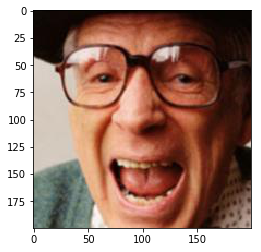

In [199]:
image  = imread('/jupyteruser/41400447/Project/crop_part1/83_0_0_20170111223725228.jpg.chip.jpg')
plt.imshow(image )

In [200]:
detector = MTCNN()
print(detector.detect_faces(image))

[{'box': [33, -13, 154, 216], 'confidence': 0.9997296929359436, 'keypoints': {'left_eye': (66, 58), 'right_eye': (139, 61), 'nose': (94, 106), 'mouth_left': (70, 144), 'mouth_right': (134, 146)}}]


In [197]:
detector

In [202]:
result = detector.detect_faces(image)

# Result is an array with all the bounding boxes detected. We know that for 'ivan.jpg' there is only one.
bounding_box = result[0]['box']
keypoints = result[0]['keypoints']

cv2.rectangle(image,
              (bounding_box[0], bounding_box[1]),
              (bounding_box[0]+bounding_box[2], bounding_box[1] + bounding_box[3]),
              (0,155,255),
              2)

cv2.circle(image,(keypoints['left_eye']), 2, (0,155,255), 2)
cv2.circle(image,(keypoints['right_eye']), 2, (0,155,255), 2)
cv2.circle(image,(keypoints['nose']), 2, (0,155,255), 2)
cv2.circle(image,(keypoints['mouth_left']), 2, (0,155,255), 2)
cv2.circle(image,(keypoints['mouth_right']), 2, (0,155,255), 2)

cv2.imwrite("ivan_drawn.jpg", image)

print(result)

[{'box': [33, -13, 154, 216], 'confidence': 0.9997296929359436, 'keypoints': {'left_eye': (66, 58), 'right_eye': (139, 61), 'nose': (94, 106), 'mouth_left': (70, 144), 'mouth_right': (134, 146)}}]


## Load Data

In [204]:
import PIL
import numpy as np
import config as cg

def load_data(path='', shape=None, mode='eval'):

    short_size = 224.0
    crop_size = shape
    img = PIL.Image.open(path)
    im_shape = np.array(img.size)    # in the format of (width, height, *)
    img = img.convert('RGB')

    ratio = float(short_size) / np.min(im_shape)
    img = img.resize(size=(int(np.ceil(im_shape[0] * ratio)),   # width
                           int(np.ceil(im_shape[1] * ratio))),  # height
                     resample=PIL.Image.BILINEAR)

    x = np.array(img)  # image has been transposed into (height, width)
    newshape = x.shape[:2]
    if mode == 'eval':    # center crop
        h_start = (newshape[0] - crop_size[0])//2
        w_start = (newshape[1] - crop_size[1])//2
    else:
        raise IOError('==> unknown mode.')
    x = x[h_start:h_start+crop_size[0], w_start:w_start+crop_size[1]]
    x = x[:, :, ::-1] - cg.mean
    return x